In [17]:
import pandas as pd
import numpy as np

In [18]:
with open("ratemd.25k.all.txt") as f:
    file = f.read()

# Task 1

In [19]:
data = []
file = file.strip()
for i in file.split("\n"):
    temp = i.split("\t")
    if len(temp) == 4:
        data.append(temp)
    elif len(temp) == 2:
        data[len(data)-1].append(temp)
    else:
        print(temp)
        raise ValueError('Wrong Length!')

In [20]:
data = pd.DataFrame(columns=['name','gender','location','special','rating','review'])

In [21]:
file = file.strip()
info = None
data = pd.DataFrame(columns=['name','gender','location','special','rating','review'])

for i in file.split("\n"):
    temp = i.split(" \t ")
    if len(temp) == 4:
        info = temp
    elif len(temp) == 2:
        temp[0] = float(temp[0].split(":")[1])
        data = data.append(dict(zip(['name','gender','location','special','rating','review'],info+temp)),\
                    ignore_index=True)
    else:
        print(temp)
        raise ValueError('Wrong Length!')

In [22]:
data["length"] = data.apply(lambda x: len(x.review.split(" ")), axis=1)

In [23]:
data["sentiment"] = data.rating >= 4

In [24]:
data.describe()

,rating,length
count,20421.000000,20421.000000
mean,3.741528,62.998531
std,1.480634,60.164758
min,0.750000,1.000000
25%,2.250000,22.000000
50%,4.500000,45.000000
75%,5.000000,85.000000
max,5.000000,899.000000


In [25]:
data.shape

(20421, 8)

In [26]:
data[data.length==1].head()

,name,gender,location,special,rating,review,length,sentiment
6,Dr. David H. Liem,Male,"Downey, CA",Emergency Room Doctor,3.00,,1,False
16,Dr. Jamie L. Mcginness,Male,"Springfield, IL",Dermatologist,4.75,,1,True
33,Dr. Michael S. Mcnevin,Male,"Spokane, WA",Surgeon (general),3.50,,1,False
47,Dr. Amer Salhadar,Male,"Brownsville, TX",Cardiologist,3.25,,1,False
86,Dr. Evelina Bernardino,Female,"Langhorne, PA",Dermatologist,3.75,,1,False


In [27]:
import seaborn as sns
%matplotlib inline
sns.set()

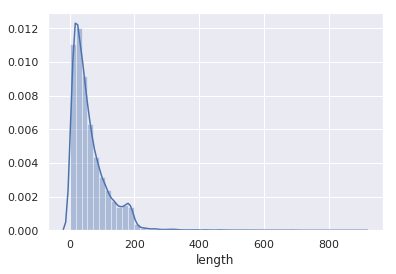

In [28]:
sns.distplot(data.length)

In [29]:
print(data[(data.gender == "Male") & (data.sentiment) ].count())

name         9877
gender       9877
location     9877
special      9877
rating       9877
review       9877
length       9877
sentiment    9877
dtype: int64


# Task 2 
## Problem 1

In [33]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import re, string

stop_words = set(stopwords.words('english'))

In [31]:
def clean(doc):
    tokenized = word_tokenize(doc.lower())
    stop_free = [x for x in tokenized if not re.fullmatch('[' + string.punctuation + ']+', x) \
                 and x not in stop_words]
    y = [s for s in stop_free if len(s) > 2]
    return y


def lda_wo_lm(k):
    doc_list = [i for i in list(data.review) if len(i.strip())!=0]
    stop_words = set(stopwords.words('english'))
    corpus_clean = [clean(doc.strip()) for doc in doc_list]
    dictionary = corpora.Dictionary(corpus_clean)
    corpus = [dictionary.doc2bow(doc_clean) for doc_clean in corpus_clean]
    new_corpus = []
    for doc in corpus:
        new_list = []
        for word_count in doc:
            if word_count[1] > 4:
                new_list.append(word_count)
        new_corpus.append(new_list)
    corpus = new_corpus
    ldamodel = LdaModel(corpus, num_topics=k, id2word = dictionary, passes=20, iterations=2000)
    return ldamodel.print_topics(num_topics=k, num_words=10)

In [34]:
p1 = lda_wo_lm(10)

In [35]:
p1

[(0,
  '0.010*"patient" + 0.009*"asked" + 0.009*"could" + 0.006*"hand" + 0.006*"never" + 0.004*"problem" + 0.003*"even" + 0.003*"tip" + 0.003*"called" + 0.003*"bill"'),
 (1,
  '0.036*"told" + 0.012*"test" + 0.009*"father" + 0.008*"procedure" + 0.007*"first" + 0.006*"skin" + 0.004*"family" + 0.004*"woman" + 0.004*"arm" + 0.003*"pap"'),
 (2,
  '0.024*"son" + 0.023*"said" + 0.011*"call" + 0.009*"mother" + 0.006*"goodman" + 0.005*"eye" + 0.005*"flu" + 0.004*"physical" + 0.004*"one" + 0.004*"steroids"'),
 (3,
  '0.083*"surgery" + 0.041*"pain" + 0.036*"would" + 0.008*"breast" + 0.005*"dad" + 0.003*"surgeon" + 0.003*"\'ve" + 0.003*"clinic" + 0.002*"knee" + 0.002*"ask"'),
 (4,
  '0.102*"doctor" + 0.023*"husband" + 0.012*"schwartz" + 0.008*"daughter" + 0.008*"get" + 0.004*"visit" + 0.003*"therapy" + 0.003*"patel" + 0.003*"evan" + 0.002*"dr.shakiba"'),
 (5,
  '0.215*"dr." + 0.015*"shakiba" + 0.006*"pasquale" + 0.005*"hollie" + 0.005*"rivadeneira" + 0.005*"dyer" + 0.004*"kolb" + 0.003*"comeau" + 

# Task 2
## Problem 2

In [42]:
def clean_lm(doc):
    tokenized = word_tokenize(doc.lower())
    stop_free = [x for x in tokenized if not re.fullmatch('[' + string.punctuation + ']+', x) \
                 and x not in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemma_verb = [lemmatizer.lemmatize(word,'v') for word in stop_free]
    lemma_noun = [lemmatizer.lemmatize(word,'n') for word in lemma_verb]
    y = [s for s in stop_free if len(s) > 2]
    return y

def lda(k):
    doc_list = [i for i in list(data.review) if len(i.strip())!=0]
    lemmatizer = WordNetLemmatizer()
    corpus_clean = [clean_lm(doc.strip()) for doc in doc_list]
    dictionary = corpora.Dictionary(corpus_clean)
    corpus = [dictionary.doc2bow(doc_clean) for doc_clean in corpus_clean]

    new_corpus = []
    for doc in corpus:
        new_list = []
        for word_count in doc:
            if word_count[1] > 4:
                new_list.append(word_count)
        new_corpus.append(new_list)

    corpus = new_corpus

    ldamodel = LdaModel(corpus, num_topics=k, id2word = dictionary, passes=20, iterations=2000)
    
    return ldamodel.print_topics(num_topics=k, num_words=10)

In [43]:
p2 = lda(10)

In [44]:
print(p1)
print(p2)

[(0, '0.010*"patient" + 0.009*"asked" + 0.009*"could" + 0.006*"hand" + 0.006*"never" + 0.004*"problem" + 0.003*"even" + 0.003*"tip" + 0.003*"called" + 0.003*"bill"'), (1, '0.036*"told" + 0.012*"test" + 0.009*"father" + 0.008*"procedure" + 0.007*"first" + 0.006*"skin" + 0.004*"family" + 0.004*"woman" + 0.004*"arm" + 0.003*"pap"'), (2, '0.024*"son" + 0.023*"said" + 0.011*"call" + 0.009*"mother" + 0.006*"goodman" + 0.005*"eye" + 0.005*"flu" + 0.004*"physical" + 0.004*"one" + 0.004*"steroids"'), (3, '0.083*"surgery" + 0.041*"pain" + 0.036*"would" + 0.008*"breast" + 0.005*"dad" + 0.003*"surgeon" + 0.003*"\'ve" + 0.003*"clinic" + 0.002*"knee" + 0.002*"ask"'), (4, '0.102*"doctor" + 0.023*"husband" + 0.012*"schwartz" + 0.008*"daughter" + 0.008*"get" + 0.004*"visit" + 0.003*"therapy" + 0.003*"patel" + 0.003*"evan" + 0.002*"dr.shakiba"'), (5, '0.215*"dr." + 0.015*"shakiba" + 0.006*"pasquale" + 0.005*"hollie" + 0.005*"rivadeneira" + 0.005*"dyer" + 0.004*"kolb" + 0.003*"comeau" + 0.003*"kurtz" + 0

In [45]:
[" ".join(i[1].split('"')[1::2]) for i in p1]

['patient asked could hand never problem even tip called bill',
 'told test father procedure first skin family woman arm pap',
 'son said call mother goodman eye flu physical one steroids',
 "surgery pain would breast dad surgeon 've clinic knee ask",
 'doctor husband schwartz daughter get visit therapy patel evan dr.shakiba',
 'dr. shakiba pasquale hollie rivadeneira dyer kolb comeau kurtz germin',
 'appointment see exam back lopez child room routine ever body',
 'office insurance staff doc really cancer wife code kwant company',
 "n't time nurse mckay patients always medication techs waiting simponi",
 'tooth like nose thyroid best went hip cavity germin results']

In [46]:
[" ".join(i[1].split('"')[1::2]) for i in p2]

["pain appointment could wife dad 've knee ultrasound ask months",
 'told test like back never pap results jaller blomain fillers',
 'dr. office shakiba pasquale hollie rivadeneira dyer kolb comeau kurtz',
 'surgery would patient breast exam went room surgeon kakani comp',
 'said tooth see get nose best really physical therapy cavity',
 'mother procedure first medication skin eye flu problem family one',
 "n't thyroid mckay hip health techs vanessa simponi tissue problems",
 'son call father doc visit lopez child goodman germin susie',
 'doctor husband schwartz asked daughter cancer patel evan dr.shakiba kidney',
 'time insurance staff hand nurse patients always code kwant company']

# Task 2
## Problem 3

## Extra-credit

In [47]:
p3 = lda_wo_lm(20)
p4 = lda(20)

In [48]:
[" ".join(i[1].split('"')[1::2]) for i in p3]

['hand never implants hospital rodas lowe relative sommer colonoscopy vengalil',
 "n't appointment asked mckay patients techs medication simponi vanessa tissue",
 'like germin tests even sister need daddy boat excellent feel',
 'pain insurance staff kwant company later dollars cover dental drug',
 'tooth child steroids cavity body free team moles scars nothing',
 'thyroid nurse hip flu waiting problems kids mild moderate emch',
 'patient doc exam always lopez room routine medication fillers kim',
 'office told test cancer wife code pap maz billing billed',
 'dr. time shakiba see pasquale hollie dyer kolb rivadeneira comeau',
 'father procedure first skin family one woman urinate bill stockall',
 'surgery breast ask rivadeneira clark meadows weeks great long diverticulitis',
 'son really goodman health susie saad cashay schoenberg injections school',
 'said get physical therapy far people glazer mom atit kraus',
 'call nose problem ever called new probst valuable year green',
 'doctor h

In [49]:
[" ".join(i[1].split('"')[1::2]) for i in p4]

['wife dad always lopez ever need mom bohay kaplan dare',
 'would code urinate billing knee comp stockall scope explained corrected',
 'mother really one people far hour green year work appt',
 'told test call pap results melissa kristensen team check pulmonary',
 'never health clinic diet brother injections moles scars neck acupuncture',
 'best child even body free fillers blomain sister schoenberg two',
 "n't cancer nurse mckay techs simponi tissue vanessa know nexium",
 'time back went patients new ankle records sojourner valuable rude',
 'surgery office breast maz ask rivadeneira pharmacy weeks take long',
 'nose hip arm ride problems hospital mild meadows redding excellent',
 'exam medication hand problem room steroids routine tip kids emch',
 'eye visit called waiting lasik implants kim laser bussell lasers',
 'tooth doc cavity tests treatment lab apt goldhaber pathology barrett',
 'doctor husband schwartz daughter get therapy patel evan dr.shakiba kraus',
 'appointment patient c

It's not really better than those with 10 topics, since 
    1. when the number of topic increases, time complexity for training and convergence increases;
    2. the topic models are not really improved they are getting more noises than 10 topics.

In [50]:
data.head()

,name,gender,location,special,rating,review,length,sentiment
0,Dr. Roger Bigelow,Male,"Warren, MI",Surgeon (general),5.00,Dr. Bigelow is the best Dr. I have ever encoun...,52,True
1,Dr. Freda L. Dreher,Female,"Lebanon, NH",Orthopedic Surgeon,5.00,Dr. Dreher always spends a LOT of time with me...,22,True
2,Dr. Audrey Konow,Female,"Placentia, CA",Internist / Geriatrician,1.75,Almighty dollar and her personal time seems va...,54,False
3,Dr. Audrey Konow,Female,"Placentia, CA",Internist / Geriatrician,5.00,The office is beautiful and the doctor did eve...,14,True
4,Dr. Thomas Dascoli,Male,"Indianapolis, IN",Family Doctor / G.P.,5.00,I was having some odd symptoms and had struggl...,143,True


In [51]:
doc_list = [i for i in list(data.review) if len(i.strip())!=0]
lemmatizer = WordNetLemmatizer()
corpus_clean = [clean_lm(doc.strip()) for doc in doc_list]

Further, split each collection in two subcollections on the sentiment dimension: C1.1 (positive reviews about female doctors) and C1.2 (negative reviews about female doctors), etc.

In [61]:
c11 = list(data[data.gender=="Female"][data.sentiment == True].review)
c12 = list(data[data.gender=="Female"][data.sentiment == False].review)
c21 = list(data[data.gender=="Male"][data.sentiment == True].review)
c22 = list(data[data.gender=="Male"][data.sentiment == False].review)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [66]:
def output_clean(topic_num, doc_list):
    doc_list = [i for i in list(doc_list) if len(i.strip())!=0]
    lemmatizer = WordNetLemmatizer()
    corpus_clean = [clean_lm(doc.strip()) for doc in doc_list]
    cc = [" ".join([str(topic_num)] + i) for i in corpus_clean]
    return ("\n".join(cc))

In [72]:
with open("corpus_clean.txt",'w') as c:
    content = "\n".join([output_clean(0,c11),output_clean(1,c12),output_clean(2,c21),output_clean(3,c22)])
    c.write(content)

next step we run these commands:

javac LearnTopicModel.java

java LearnTopicModel -model cclda -input corpus_clean.txt -iters 2000 -Z 10

python2 topwords_cclda.py corpus_clean.txt.assign > out.txt